In [23]:
import os
import subprocess

import torch
import numpy as np
import soundfile as sf
import librosa
import librosa.display
import noisereduce as nr
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import IPython.display as ipd
from panns_inference import AudioTagging

In [24]:
# ─── PARAMETERS ──────────────────────────────────────────────────────────────
PANNS_SR          = 32000      # 32 kHz
WINDOW_SEC        = 1.0        # 1 s windows
THRESH            = 0.5        # bird‑presence threshold
BAND_ALPHA        = 2.0        # filter boost factor
LOWCUT            = 2000       # Hz
HIGHCUT           = 8000       # Hz
PROP_DECREASE     = 0.9        # noise‑reduction
STATIONARY_NOISE  = False

# paths
audio_file_path            = "../SampleAudio.ogg"
output_dn_path             = "../SampleAudio_nr.wav"
output_aug_path            = "../SampleAudio_aug.wav"
output_aug_dn_path         = "../SampleAudio_aug_dn.wav"
ckpt_dir                   = "/home/jovyan/panns_data"
ckpt_file                  = os.path.join(ckpt_dir, "Cnn14_mAP=0.431.pth")

bird_class_idxs = [
    14,22,27,28,33,34,35,37,40,
    72,73,80,84,
    *range(98,107),108,
    *range(111,122),
    *range(126,133),
    137,361,442,503
]

In [25]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def augment_waveform_with_filter(wave, mask, sr,
                                 lowcut=LOWCUT, highcut=HIGHCUT,
                                 alpha=BAND_ALPHA):
    b, a = butter_bandpass(lowcut, highcut, sr, order=4)
    # zero‑phase filtering
    wave_band = filtfilt(b, a, wave)
    wave_aug  = wave.copy()
    win_len   = int(WINDOW_SEC * sr)
    for i, m in enumerate(mask):
        if m:
            start = i * win_len
            end   = min((i+1) * win_len, len(wave))
            # add boosted band signal
            wave_aug[start:end] = wave[start:end] + alpha * wave_band[start:end]
    # normalize to avoid clipping
    peak = np.max(np.abs(wave_aug))
    if peak > 1.0:
        wave_aug /= peak
    return wave_aug

def get_per_window_mask(wave_dn, model, device, sr):
    win_len   = int(WINDOW_SEC * sr)
    n_windows = int(np.ceil(len(wave_dn) / win_len))
    mask = []
    for w in range(n_windows):
        seg = wave_dn[w*win_len:(w+1)*win_len]
        if len(seg) < win_len:
            seg = np.pad(seg, (0, win_len-len(seg)), mode="constant")
        inp = torch.from_numpy(seg).unsqueeze(0).to(device)
        with torch.no_grad():
            clipwise, _ = model.inference(inp)
        probs = (clipwise.squeeze(0).cpu().numpy()
                 if isinstance(clipwise, torch.Tensor)
                 else np.squeeze(clipwise,0))
        top = int(np.argmax(probs))
        mask.append(top in bird_class_idxs or probs[bird_class_idxs].max() > THRESH)
    return np.array(mask, dtype=bool)

def mel_spec_db(wave, sr=PANNS_SR):
    m = librosa.feature.melspectrogram(
        y=wave, sr=sr,
        n_fft=2048, hop_length=512,
        n_mels=128
    )
    return librosa.power_to_db(m, ref=np.max)

In [26]:
os.makedirs(ckpt_dir, exist_ok=True)
if not os.path.isfile(ckpt_file):
    subprocess.run([
        "wget","-q","-O",ckpt_file,
        "https://zenodo.org/records/3987831/files/Cnn14_mAP%3D0.431.pth?download=1"
    ], check=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
panns  = AudioTagging(checkpoint_path=None, device=device)
panns.model.eval()

Checkpoint path: /home/jovyan/panns_data/Cnn14_mAP=0.431.pth
Using CPU.


Cnn14(
  (spectrogram_extractor): Spectrogram(
    (stft): STFT(
      (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
      (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
    )
  )
  (logmel_extractor): LogmelFilterBank()
  (spec_augmenter): SpecAugmentation(
    (time_dropper): DropStripes()
    (freq_dropper): DropStripes()
  )
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_block1): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (c

In [27]:
# 1) load & resample & truncate
waveform, orig_sr = sf.read(audio_file_path, dtype="float32")
if waveform.ndim > 1:
    waveform = waveform.mean(axis=1)
wave32 = librosa.resample(waveform, orig_sr=orig_sr, target_sr=PANNS_SR)
wave32 = wave32[:int(30 * PANNS_SR)]

# 2) denoise original
wave_dn = nr.reduce_noise(
    y=wave32, sr=PANNS_SR,
    stationary=STATIONARY_NOISE,
    prop_decrease=PROP_DECREASE
)
sf.write(output_dn_path, wave_dn, PANNS_SR)

# 3) compute mask
mask = get_per_window_mask(wave_dn, panns, device, PANNS_SR)

# 4) augment audio via bandpass boost
wave_aug = augment_waveform_with_filter(wave_dn, mask, PANNS_SR)
sf.write(output_aug_path, wave_aug, PANNS_SR)

# 5) denoise augmented audio
wave_aug_dn = nr.reduce_noise(
    y=wave_aug, sr=PANNS_SR,
    stationary=STATIONARY_NOISE,
    prop_decrease=PROP_DECREASE
)
sf.write(output_aug_dn_path, wave_aug_dn, PANNS_SR)

# 6) compute MELs
mel_dn      = mel_spec_db(wave_dn)
mel_aug     = mel_spec_db(wave_aug)
mel_aug_dn  = mel_spec_db(wave_aug_dn)

▶ Original Denoised


▶ Augmented Audio


▶ Augmented then Denoised


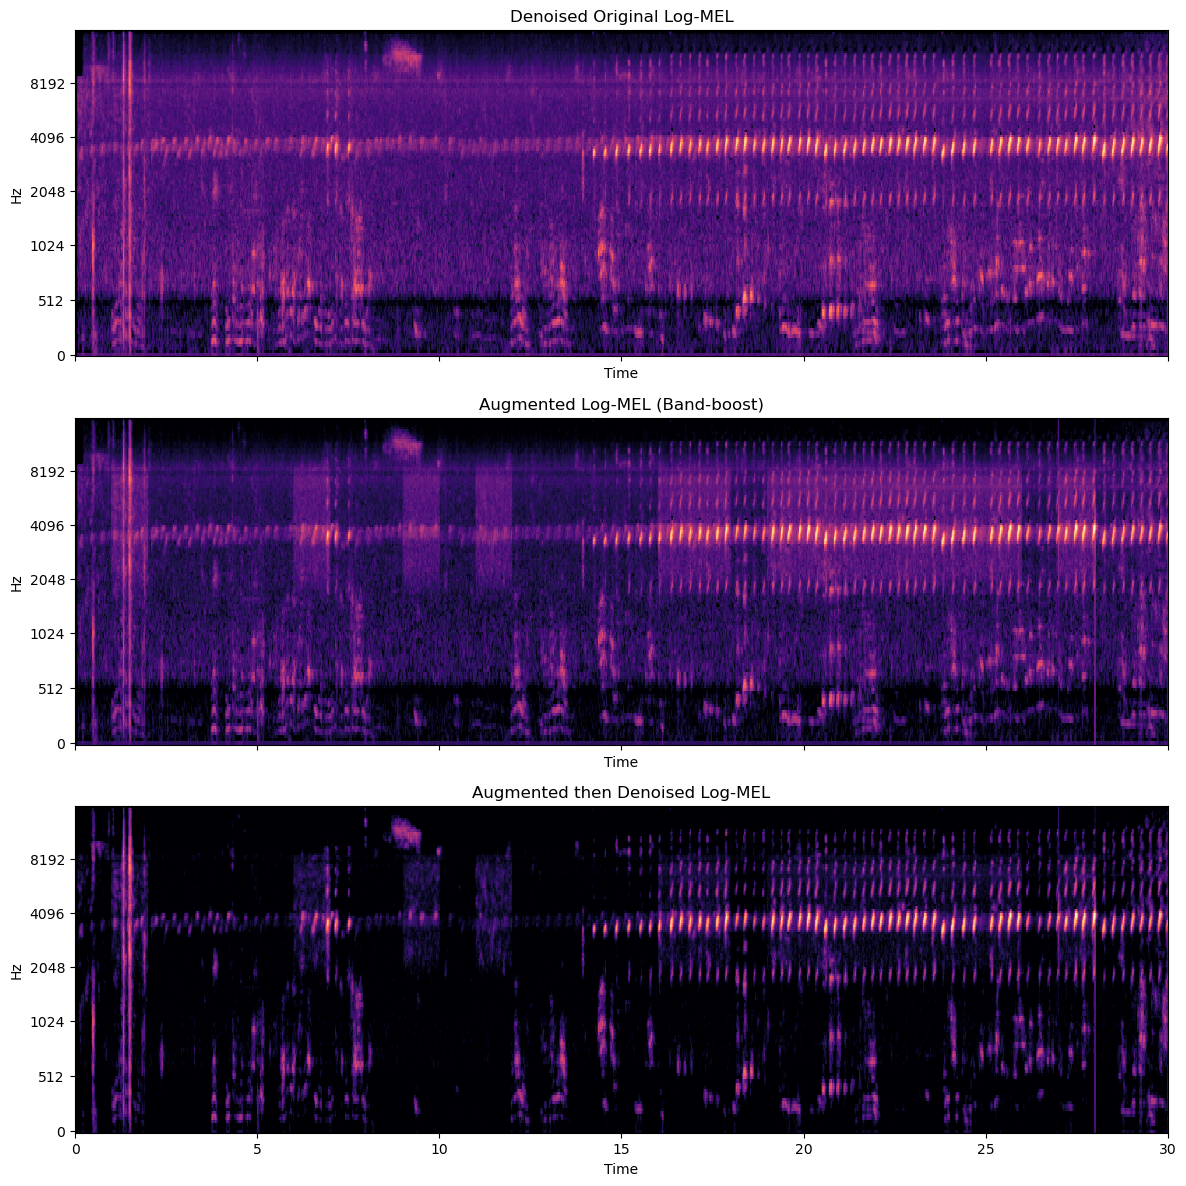

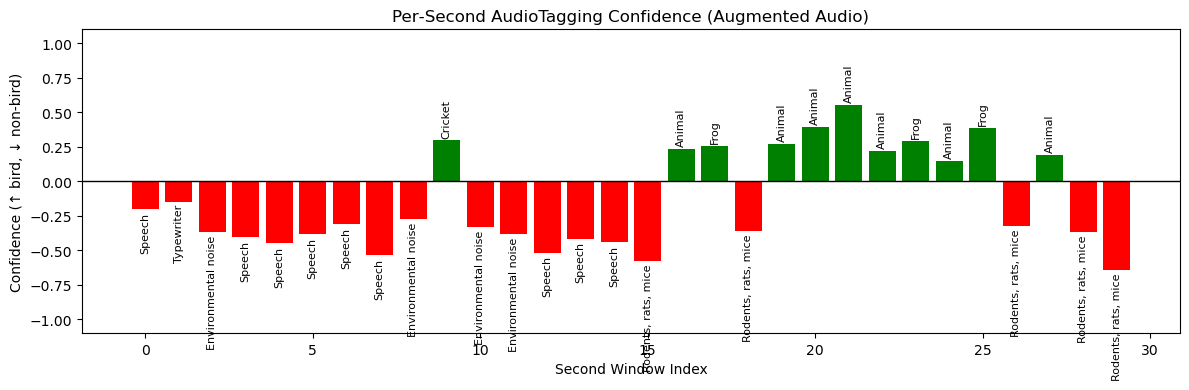

In [28]:
print("▶ Original Denoised");     ipd.display(ipd.Audio(wave_dn,     rate=PANNS_SR))
print("▶ Augmented Audio");        ipd.display(ipd.Audio(wave_aug,    rate=PANNS_SR))
print("▶ Augmented then Denoised"); ipd.display(ipd.Audio(wave_aug_dn, rate=PANNS_SR))

# ─── PLOT: MEL SPECTROGRAMS ───────────────────────────────────────────────────
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,12), sharex=True)
librosa.display.specshow(mel_dn,      sr=PANNS_SR, hop_length=512, x_axis='time', y_axis='mel', ax=ax1)
ax1.set_title("Denoised Original Log‑MEL")
librosa.display.specshow(mel_aug,     sr=PANNS_SR, hop_length=512, x_axis='time', y_axis='mel', ax=ax2)
ax2.set_title("Augmented Log‑MEL (Band‑boost)")
librosa.display.specshow(mel_aug_dn,  sr=PANNS_SR, hop_length=512, x_axis='time', y_axis='mel', ax=ax3)
ax3.set_title("Augmented then Denoised Log‑MEL")
plt.tight_layout(pad=1.2)
plt.show()

# ─── PLOT: per‑second confidence bars ──────────────────────────────────────────
win_len   = int(WINDOW_SEC * PANNS_SR)
n_seconds = int(np.ceil(len(wave_aug) / win_len))

top_idxs    = []
confidences = []
is_bird     = []

for w in range(n_seconds):
    start = w * win_len
    end   = min((w+1) * win_len, len(wave_aug))
    seg   = wave_aug[start:end]
    if len(seg) < win_len:
        seg = np.pad(seg, (0, win_len - len(seg)), mode="constant")
    inp = torch.from_numpy(seg).unsqueeze(0).to(device)
    with torch.no_grad():
        clipwise, _ = panns.inference(inp)
    # convert to NumPy if necessary
    probs = (clipwise.squeeze(0).cpu().numpy()
             if isinstance(clipwise, torch.Tensor)
             else np.squeeze(clipwise, axis=0))
    top = int(np.argmax(probs))
    top_idxs.append(top)
    confidences.append(float(probs[top]))
    is_bird.append(top in bird_class_idxs)

# prepare bar values and colors
values = [c if b else -c for c, b in zip(confidences, is_bird)]
colors = ['green' if b else 'red' for b in is_bird]
x      = np.arange(n_seconds)

# draw
plt.figure(figsize=(12, 4))
plt.axhline(0, color='black', linewidth=1)
plt.bar(x, values, color=colors, width=0.8)

# annotate with labels
for i, (v, idx) in enumerate(zip(values, top_idxs)):
    plt.text(
        i,
        v + (0.02 if v > 0 else -0.02),
        panns.labels[idx],
        ha='center',
        va='bottom' if v > 0 else 'top',
        rotation=90,
        fontsize=8
    )

plt.xlabel("Second Window Index")
plt.ylabel("Confidence (↑ bird, ↓ non‑bird)")
plt.title("Per‑Second AudioTagging Confidence (Augmented Audio)")
plt.ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()

In [7]:
print("Number of birdy windows:", mask.sum(), "out of", len(mask))

Number of birdy windows: 14 out of 30


In [8]:
# 1. Setup Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")
panns_model = None
try:
    print("Loading PANNs Cnn14 model...")
    panns_model = AudioTagging(checkpoint_path=None, device=device)
    panns_model.model.eval()
    print("PANNs Model loaded.")
except Exception as e:
    print(f"Fatal Error: Could not load PANNs model: {e}")
    panns_model = None

Using device: cuda
Loading PANNs Cnn14 model...
Checkpoint path: /home/jovyan/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
PANNs Model loaded.


In [9]:
for i, label in enumerate(panns_model.labels):
    print(f"{i:3d}: {label}")

  0: Speech
  1: Male speech, man speaking
  2: Female speech, woman speaking
  3: Child speech, kid speaking
  4: Conversation
  5: Narration, monologue
  6: Babbling
  7: Speech synthesizer
  8: Shout
  9: Bellow
 10: Whoop
 11: Yell
 12: Battle cry
 13: Children shouting
 14: Screaming
 15: Whispering
 16: Laughter
 17: Baby laughter
 18: Giggle
 19: Snicker
 20: Belly laugh
 21: Chuckle, chortle
 22: Crying, sobbing
 23: Baby cry, infant cry
 24: Whimper
 25: Wail, moan
 26: Sigh
 27: Singing
 28: Choir
 29: Yodeling
 30: Chant
 31: Mantra
 32: Male singing
 33: Female singing
 34: Child singing
 35: Synthetic singing
 36: Rapping
 37: Humming
 38: Groan
 39: Grunt
 40: Whistling
 41: Breathing
 42: Wheeze
 43: Snoring
 44: Gasp
 45: Pant
 46: Snort
 47: Cough
 48: Throat clearing
 49: Sneeze
 50: Sniff
 51: Run
 52: Shuffle
 53: Walk, footsteps
 54: Chewing, mastication
 55: Biting
 56: Gargling
 57: Stomach rumble
 58: Burping, eructation
 59: Hiccup
 60: Fart
 61: Hands
 62: Fin